<center> 
    <h1>Font Generation using DCGAN</h1>
</center>

<h2> DCGAN</h2>
In 2015 DCGAN was proposed that in summary gave some architectural guidelines and other tricks that improved GANs training and generated better results. If you are interested have a look at <a href="https://arxiv.org/pdf/1511.06434.pdf", target="_blank"/>DCGAN paper</a>. <br>
Below are some of the guidelines from the orignal DCGAN paper. <br><br>
<img src="../Figures/DCGAN-Guide-lines.png" width=600 height=600 />
<br>
And below is the Generator architecture of DCGAN<br><br>
<img src="../Figures/DCGAN_arch.PNG" width=600 height=600 />

<h2> Lab Overview </h2>
This lab uses our custom font alphabet dataset and trains a DCGAN on it to later generate font characters. Following are the key points we will cover in this lab.
<ol>
    <li>Importing required libraries </li>
    <li>Dataset preparation and loading</li>
    <li>Network architecture</li>
    <li>Loss and optimizer</li>
    <li>Training</li>
    <li>Creating a GIF</li>
</ol>    

<h2>Importing required libraries</h2>
Let's import the required libraries for this lab.

In [2]:
import tensorflow as tf
tf.__version__

'2.1.0'

To create GIF image we need to install imageio. Run the below command.

In [2]:
pip install -q imageio

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importing other modules required for this lab
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import pathlib
from  tensorflow.keras.initializers  import  RandomNormal 

from IPython import display

<h2>Dataset preparation and loading</h2>
Now we need to prepare and load our dataset. As we want to create our own font dataset, I have provided a dataset module named "data_generation" in our root directory. This directory has mainly three sub-directories.
<ul>
    <li>fonts</li> (contains the TrueType font files)
    <li>labels</li> (contains the labels of the characters we want to generate )
    <li>tools</li> (contains python files for generating font images by utlizing fonts and labels above)
</ul>
Open the terminal and run the below command to generate dataset for this lab (lab2). Make sure to activate your environment, <b>tutorial-TF</b> in our case. <br><br>
<code>python ./data_generation/tools/Lab2_DCGAN/lab2-dataset-generator.py</code><br><br>
This will create a new directory in root with name "Lab2-image-data/font-images" containing (64,64) dimensional images which we will use for training our DCGAN.<br>
<b>Note</b> It will generate n*26 number of images where n is the total number of fonts in our fonts directory and 26 are the total number of character labels in the labels directory. 

Ok so far so good. Lets create an input pipeline in TensorFlow to load the data for our model. We will utilize the <a href="https://www.tensorflow.org/api_docs/python/tf/data/Dataset" target="_blank">Dataset api</a> which is an API for input pipelines in TensorFlow. <br>
First we will setup the path of the image directory by running the below code.  

In [4]:
# Setting up paths for the input images
SCRIPT_PATH = os.path.join(os.getcwd())
path_to_img_dir = os.path.join(SCRIPT_PATH, '../Lab2-image-data/font-images/')

In [5]:
# Counting the total number of font images on our image directory
data_dir = pathlib.Path(path_to_img_dir)
image_count = len(list(data_dir.glob('*.png')))
print(image_count)

78


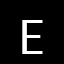

In [6]:
# Let's display out any random image from the image direcotory
images = list(data_dir.glob('*'))
PIL.Image.open(str(images[4]))

So far we have the list of all the paths of the images however our tensorflow model doesnt need this. For this we need to convert these paths into numpy array format so that we can pass it to the model later. For this, below we create a function that will return us all the images as a numpy array with a dimension <b>64x64x1</b>.

In [1]:
# Given a path below functions extracts the name of the file from it
def get_name(path):
    name, typeis = os.path.splitext(os.path.basename(path))
    return name

# get_imgs_labels(path) takes the path of the image directory and returns a list containg all images full paths.  
# The return type is <class 'list'>
# Then we take individual path from the list and create a numpy array with desired size
def get_imgs_labels(input_dir):
    if input_dir is None or not os.path.exists(input_dir):
        raise Exception("input_dir does not exist")

    input_paths = glob.glob(os.path.join(input_dir, "*.png"))

    if len(input_paths) == 0:
        raise Exception("input_dir contains no image files")

    # if the image names are numbers, sort by the value rather than asciibetically
    # having sorted inputs means that the outputs are sorted in test mode
    if all(get_name(path).isdigit() for path in input_paths):
        input_paths = sorted(input_paths, key=lambda path: int(get_name(path)))
    else:
        input_paths = sorted(input_paths)

    # Preprocess individual path and convert into numpy array with desired size
    training_data = []
    for path in input_paths:
        image = PIL.Image.open(path).resize((64,
                64),PIL.Image.ANTIALIAS)
        training_data.append(np.asarray(image))
    training_data = np.reshape(training_data,(-1,64,64,1))
    
    return np.asarray(training_data)

In [8]:
# call the function to get all images into desired type and dimension
train_images = get_imgs_labels(data_dir)

In [9]:
# Lets reshape and normalize the images
train_images = train_images.reshape(train_images.shape[0], 64,64,1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
print(train_images.shape)

(78, 64, 64, 1)


In [10]:
# This is where we use the dataset Api. We call a batch of data according to our Batch size
# Batch and shuffle the data
BUFFER_SIZE = 60000
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

So far so good. So in summary above we created our dataset pipeline using tf.data api. We created a function to get all the images in numpy array format, then we reshaped them and apply some normalization. Then we called <b>tf.data.Dataset.from_tensor_slices()</b> to actually get the input data for our model. 

<h2>Network architecture</h2>

So now let's build our model. Remember in GAN we have a Generator and a Discriminator. So we will create both of these networks by following the architectural guidelines from the paper as shown above to make it a DCGAN.<br><br>
<b>Generator</b>
<br>
The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 64x64x1. Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh. 

In [11]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(4*4*256,activation="relu",input_shape=(100,)))
    model.add(layers.Reshape((4,4,256)))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(256,kernel_size=3,padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(256,kernel_size=3,padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128,kernel_size=3,padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(128,kernel_size=3,padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    # Final CNN layer
    model.add(layers.Conv2D(1,kernel_size=3,padding="same"))
    model.add(layers.Activation("tanh"))

    return model

Lets pass a random noise and see what our untrained Generator outputs

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 256)         590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
activation (Activation)      (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 256)       0

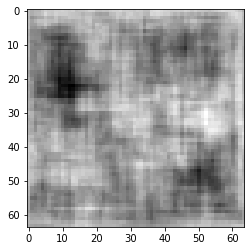

In [12]:
generator = make_generator_model()
generator.summary()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

<b>Discriminator</b>
<br>
The discriminator is a CNN-based image classifier. The job of Discriminator is to classify the input image. Its a binary classification problem between real and fake prediction so we have utilized sigmoid activation function at the end of it.

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=[64, 64, 1], 
                     padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [14]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 17, 17, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 17, 17, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 17, 17, 64)       

<h2>Loss and optimizer</h2>
Let's define our loss function and optimizers for both models. 

In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

<b> Discriminator Loss</b>
<br>
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

<b> Generator Loss</b>
<br>
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

<b>Generator and Disriminator optimizers</b>
<br>
The discriminator and the generator optimizers are different since we will train two networks separately.

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

<b>Saving model checkpoints</b>
<br>
Let's see how we can save and restore our trained model. Later we will call the below code to save the model after N number of epochs. Once the training is finished we can load the trained model and generate new data. This helps especially when you have a big dataset and takes hours or days to train a network. (You dont want to train models again and again)

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

<h2>Training </h2>
So, now the data pipeline, the network architecture, losses, optimizers and other required things are ready now we move on to another important point where we write the code for training our model. 
<br>
<b> Define the training loop</b>

In [20]:
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, noise_dim])

  # Record operations for automatic differentiation.
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    
    # Calculate gradients of both networks seperately
    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    # Apply the gradients (Training) manually modifying weights manually
    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [22]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            t = train_step(image_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])

        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            # Produce images for the GIF as we go
            display.clear_output(wait=True)
            generate_and_save_images(generator,
                                     epoch + 15,
                                     seed)

        print ('Time for epoch {} is {} sec generator loss is {} and Discriminator loss is {}'.format(epoch + 1, time.time()-start, g_loss, d_loss))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

Lets write a function to save an image every epoch.
<b>Generate and save images</b>

In [23]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

<b>Train the model</b><br>
Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated characters will look increasingly real. 

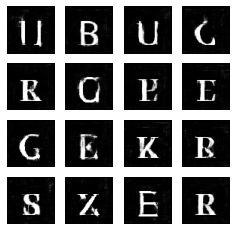

In [24]:
train(train_dataset, EPOCHS)

Now lets restore our checkpoints

In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

<h2>Create a GIF</h2>
Now we will create a GIF image that will show us how our model started with a noise and then finally learnt to create these alphabets. You can also refer to this GIF image as an interpolation from starting image to the lastly generated image.

In [26]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

Use imageio to create an animated gif using the images saved during training.

In [27]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [28]:
pip install -q git+https://github.com/tensorflow/docs

Note: you may need to restart the kernel to use updated packages.



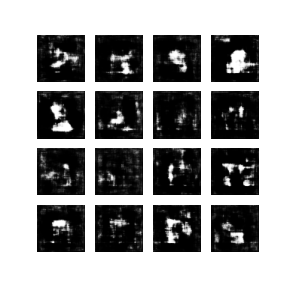

In [29]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)